In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geemap
import ee
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform

In [3]:
try:
    ee.Initialize()
    print("Initialization successful")
except Exception as e:
    print(f"Error: authentication needed")
    ee.Authenticate()
    ee.Initialize()
    print("Initialization successful")


Initialization successful


In [10]:
#TS function
def dailyNBARmaskFunc(img):
    qa = img.select('BRDF_Albedo_Band_Mandatory_Quality_Band1')
    qa2 = img.select('BRDF_Albedo_Band_Mandatory_Quality_Band2')
    Quality = bitwiseExtract(qa, 0)
    Qualityb2 = bitwiseExtract(qa2, 0)
    mask = Quality.eq(0)\
        .And(Qualityb2.eq(0))\


    maskedImage = img.updateMask(mask)

    return maskedImage

def dailyNBARNDVI(img):
    ndvi = img.normalizedDifference(['Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band1']).rename('NDVI').set('system:time_start', img.get('system:time_start'))
    return img.addBands(ndvi)

def bitwiseExtract(value, fromBit, toBit=None):
    '''
    https://gis.stackexchange.com/questions/349371/creating-cloud-free-images-out-of-a-mod09a1-modis-image-in-gee/349401#349401
    '''
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)

def Getroi(img):
    
    maskedImage = img.clip(roi)
    
    return maskedImage
def rescale(image):
    date = image.get('system:time_start')
    return image.multiply(scale_factor).set('system:time_start', date)

def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=roi).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    df = pd.DataFrame({'mean' : out_vals, 'std' : out_std}, index=out_dates)
    return df


#GEE interpolation cloud comp
#credit https://spatialthoughts.com/2021/11/08/temporal-interpolation-gee/
def interpolate(image):
    image = ee.Image(image)
    date = image.get('system:time_start')
    beforeImages = ee.List(image.get('before'))
    beforeMosaic = ee.ImageCollection.fromImages(beforeImages).mosaic()
    afterImages = ee.List(image.get('after'))
    afterMosaic = ee.ImageCollection.fromImages(afterImages).mosaic()
    
    t1 = beforeMosaic.select('timestamp').rename('t1')
    t2 = afterMosaic.select('timestamp').rename('t2')
    t = image.metadata('system:time_start').rename('t')
    tImage = ee.Image.cat([t1, t2, t])
    timeRatio = tImage.expression('(t - t1) / (t2 - t1)', {'t': tImage.select('t'),'t1': tImage.select('t1'),'t2': tImage.select('t2')})

    interpolated = beforeMosaic.add((afterMosaic.subtract(beforeMosaic).multiply(timeRatio)))
    result = image.unmask(interpolated)
    return result.copyProperties(image, ['system:time_start'])

def timeImage(image):
    tI = image.metadata('system:time_start').rename('timestamp')
    timeImageMasked = tI.updateMask(image.mask().select(14))
    return image.select('NDVI').addBands(timeImageMasked)

def getsiteNDVI(roiall, NDVICollection, siteID, y_start, y_end, n):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi
    roi = ee.Geometry.MultiPolygon(coords)

    NDVI_flt = NDVICollection.filter(ee.Filter.date(y_start, y_end))
    NDVImasked = NDVI_flt.map(dailyNBARmaskFunc)
    NDVI_roimasked = NDVImasked.map(Getroi)

    NDVI_rescale = NDVI_roimasked.map(rescale)
    NDVI_rescale = NDVI_rescale.map(dailyNBARNDVI)
    #pixel based interpolation
    days = n

    millis = ee.Number(days).multiply(1000*60*60*24)

    NDVI_rescale_t = NDVI_rescale.map(timeImage)

    maxDiffFilter = ee.Filter.maxDifference(**{'difference': millis,'leftField': 'system:time_start','rightField': 'system:time_start'})

    lessEqFilter = ee.Filter.lessThanOrEquals(**{'leftField': 'system:time_start','rightField': 'system:time_start'})

    greaterEqFilter = ee.Filter.greaterThanOrEquals(**{'leftField': 'system:time_start','rightField': 'system:time_start'})

    filter1 = ee.Filter.And(maxDiffFilter, lessEqFilter)

    join1 = ee.Join.saveAll(**{'matchesKey': 'after','ordering': 'system:time_start','ascending': False})

    join1Result = join1.apply(**{'primary': NDVI_rescale_t,'secondary': NDVI_rescale_t,'condition': filter1})

    filter2 = ee.Filter.And(maxDiffFilter, greaterEqFilter)

    join2 = ee.Join.saveAll(**{'matchesKey': 'before','ordering': 'system:time_start','ascending': True})

    join2Result = join2.apply(**{'primary':join1Result, 'secondary': join1Result, 'condition': filter2})

    # Map the interpolation function over the image collection
    interpolated_collection = ee.ImageCollection(join2Result.map(interpolate))
    #interpolated_collection_ndvi =interpolated_collection.select(['NDVI']).map(lambda img:img.multiply(1).copyProperties(img, **{'properties':['system:time_start', 'system:index']}))
    TS = interpolated_collection.map(createTS)
    NDVI_ts_int = TS_to_pandas(TS)
    return NDVI_ts_int

#Season functions

def snowdf(roiall,snow, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    var = 'NDSI_Snow_Cover'

    snowcover = snow.select('NDSI_Snow_Cover').sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=snowcover.map(createTS)
    df=TS_to_pandas(ts)
    return df

def snowmaskFunc(img):
    qa = img.select('NDSI_Snow_Cover_Basic_QA')
    Quality = bitwiseExtract(qa, 0, 15) 
    mask = Quality.eq(0).Or(Quality.eq(1))


    maskedImage = img.updateMask(mask)

    return maskedImage


def LSTdf(roiall, LST, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    var = 'LST_Day_1km'
    
    LSTC = LST.select(var).sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=LSTC.map(createTS)
    df=TS_to_pandas(ts)
    return df

def LSTmaskFunc(img):
    qa = img.select('QC_Day')
    Quality = bitwiseExtract(qa, 0, 1)
    Quality2 = bitwiseExtract(qa, 2, 3) 
    mask = Quality.eq(0).Or(Quality2.eq(0))

    maskedImage = img.updateMask(mask)

    return maskedImage

def seasonrangeCal(snowts, LSTts, yt):
    lastsnow = np.array((snowts.loc[yt]['mean'][:120]>50)).nonzero()[0]
    startsnow = np.array((snowts.loc[yt]['mean'][-120:]>50)).nonzero()[0]
    spring = np.array((LSTts.loc[yt]['mean'][:120]*0.02-273.15>0)).nonzero()[0]
    winter = np.array((LSTts.loc[yt]['mean'][-120:]*0.02-273.15<0)).nonzero()[0]

    if len(lastsnow)!=0:
        start_season = snowts.loc[yt].index[lastsnow[-1]]
    elif len(spring)!=0:
        start_season = snowts.loc[yt].index[spring[0]]
    else:
        start_season = snowts.loc[yt].index[0]
    if len(startsnow)!=0:
        end_season = snowts.loc[yt].index[-120:][startsnow[0]]
    elif len(winter)!=0:
        end_season = snowts.loc[yt].index[-120:][winter[0]]
    else: 
        end_season = snowts.loc[yt].index[-1]
    return start_season, end_season

def Season(roiall, siteID, y_start, y_end):
    startL=[]
    endL=[]
    snow=ee.ImageCollection('MODIS/061/MOD10A1').filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))
    snow=snow.map(snowmaskFunc)
    snowts=snowdf(roiall, snow, siteID)

    LST=ee.ImageCollection('MODIS/061/MOD11A1').filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))
    LST=LST.map(LSTmaskFunc)
    LSTts=LSTdf(roiall, LST, siteID)
    Years = np.arange(y_start, y_end, 1)
    for y in Years:
        yt=f'{y}'
        st,ed=seasonrangeCal(snowts, LSTts, yt)
        #st,ed=seasonrangeCal(snowts,0 , yt)
        startL.append(st)
        endL.append(ed)
    df=pd.DataFrame(data={'start_season' : startL, 'end_season' : endL}, index=Years)
    return df, snowts, LSTts

#cdl function
def createTScdl(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.median(), geometry=roi).get('cropland')
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'mean': value})
    return ft

def TS_to_pandascdl(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        if len(f['properties'])==1:
            val = 0
        else:
            val = props['mean']
        out_vals[i] = val
        out_dates.append(pd.Timestamp(date))
    
    df = pd.DataFrame({'crop' : out_vals}, index=out_dates)
    return df

def cdldf(cdl, siteID):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi
    roi = ee.Geometry.MultiPolygon(coords)
    
    cropLandcover = cdl.select('cropland').sort('system:time_start').filterBounds(roi).map(Getroi)
    ts=cropLandcover.map(createTScdl)
    df=TS_to_pandascdl(ts)
    df.index=df.index.year
    return df

#sentinel 1 function
def createTSS1(image):
    date = image.get('system:time_start')
    orb = image.get('relativeOrbitNumber_start')
    slice = image.get('sliceNumber')
    VVvalue = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get('VV')
    VVmx = image.reduceRegion(reducer=ee.Reducer.max(), geometry=roi).get('VV')
    VHvalue = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi).get('VH')
    VHmx = image.reduceRegion(reducer=ee.Reducer.max(), geometry=roi).get('VH')
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), 'VVmean': VVvalue, 'VVmax':VVmx, 'VHmean': VHvalue
                           , 'VHmax':VHmx, 'orbit':orb, 'slice':slice})
    return ft

def TS_to_pandass1(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_vals2 = np.empty((len(fts)))
    out_vals3 = np.empty((len(fts)))
    out_vals4 = np.empty((len(fts)))
    out_dates = []
    out_orbits = []
    out_slices = []
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props['VVmean']
        out_vals[i] = val
        val = props['VVmax']
        out_vals2[i] = val
        val = props['VHmean']
        out_vals3[i] = val
        val = props['VHmax']
        out_vals4[i] = val
        out_dates.append(pd.Timestamp(date))
        out_orbits.append(props['orbit'])
        out_slices.append(props['slice'])
    
    df = pd.DataFrame({'VVmean' : out_vals, 'VVmax': out_vals2, 'VHmean' : out_vals3, 'VHmax': out_vals4
                       , 'orbit':out_orbits, 'slice':out_slices}, index=out_dates)
    return df

def s1data(y_start, y_end, siteID, direction = 'Ascending', orbit = None, dataset='FLOAT'):
    coords = roiall.getInfo()['features'][siteID]['geometry']['coordinates']
    global roi, var
    roi = ee.Geometry.MultiPolygon(coords)
    if dataset == 'FLOAT':
        S1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
    elif dataset == 'LOG':
        S1 = ee.ImageCollection('COPERNICUS/S1_GRD')#log-scaled (in dB)
    S1 = S1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filterBounds(roi)\
        .filter(ee.Filter.date(f'{y_start}-01-01', f'{y_end}-01-01'))

    if orbit:
        S1 = S1.filter(ee.Filter.eq('relativeOrbitNumber_start', orbit))
    if direction == 'Ascending':
        data = S1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    else:
        data = S1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    data = data.map(Getroi)
    data = data.map(createTSS1)
    df = TS_to_pandass1(data)
    return df

In [4]:
#define variables
roi_shp = 'C:/Users/Vito/Documents/p1/masklayers/potato_flt_mask.shp'
roiall = geemap.shp_to_ee(roi_shp)
cdl=ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2000-01-01', '2023-01-01'))
NDVICollection = ee.ImageCollection('MODIS/061/MCD43A4')
var = 'NDVI'
scale_factor = 0.0001

In [6]:
shapefile_path = 'C:/Users/Vito/Documents/p1/masklayers/potato_flt_mask.shp'

source_projection = Proj(init='epsg:5070')
target_projection = Proj(init='epsg:4326')  # WGS84

gdf = gpd.read_file(shapefile_path)

geometry = gdf['geometry']
epsgcenterlist=[]
wgscenterlist=[]
for geom in geometry:
    x, y = geom.centroid.x, geom.centroid.y
    lon, lat = transform(source_projection, target_projection, x, y)
    epsgcenterlist.append([x, y])
    wgscenterlist.append([lon, lat])
np.savetxt('epsgcenterlist.csv', epsgcenterlist, delimiter=',')
np.save('wgscenterlist.npy', wgscenterlist)

c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Vito\miniconda3\envs\gee\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Vito\AppData\Local\Temp\ipykernel_14712\3325219268.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

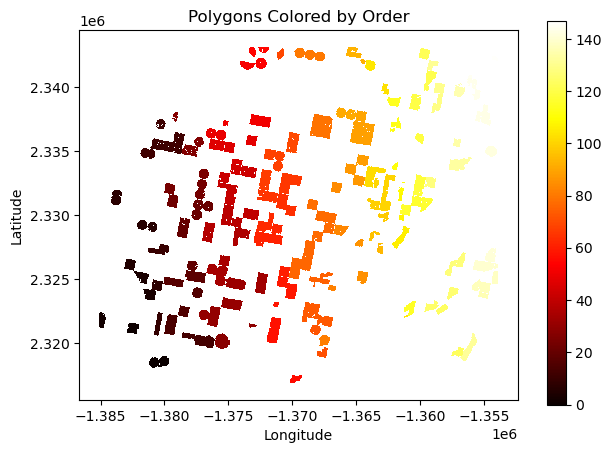

In [10]:
ax=gdf.plot(cmap='hot')

# Add title and labels
plt.title('Polygons Colored by Order')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=147))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)
# Show the plot
plt.show()


In [15]:
#sentinel 1 donwload
failed_sites = []
for i in np.arange(0,148,1):
    templist=[]
    try:
        df = s1data(2015, 2023, i, direction = 'Decending', orbit = None, dataset='LOG')
        df.to_hdf(f'sentinel1/Site{i:03}_db.h5', key='df', mode='w') 

    except Exception as e:
        print(f"Error: download failed for site {i}")
        failed_sites.append(i)
print(f"Failed sites: {failed_sites}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
Failed sites: []


In [11]:
df = s1data(2015, 2023, i, direction = 'Decending', orbit = None, dataset='LOG')

site 12 26
27
73
89
works when split in smaller batches

In [ ]:
#NDVI download
failed_sites = []
for i in np.arange(0,148,1):
    templist=[]
    for yt in np.arange(2000,2023,1):
        try:
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt+1}-01-01', 30))
        except Exception as e:
            print(f"Error: download failed for site {i} year {yt}")
            failed_sites.append(f'{i}_{yt}')
    St=pd.concat(templist, axis=0, join='inner')
    St.to_hdf(f'sites3/Site{i:03}_NBARint.h5', key='df', mode='w')
print(f"Failed sites: {failed_sites}")

In [ ]:
#NDVI download
failed_sites = []
for i in [12,26,27,73,89]:
    templist=[]
    for yt in np.arange(2000,2023,1):
        try:
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-01-01', f'{yt}-04-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-04-01', f'{yt}-07-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-07-01', f'{yt}-10-01', 30))
            templist.append(getsiteNDVI(roiall, NDVICollection, i, f'{yt}-10-01', f'{yt+1}-01-01', 30))
        except Exception as e:
            print(f"Error: download failed for site {i} year {yt}")
            failed_sites.append(f'{i}_{yt}')
    St=pd.concat(templist, axis=0, join='inner')
    St.to_hdf(f'sites3/Site{i:03}_NBARint.h5', key='df', mode='w')
print(f"Failed sites: {failed_sites}")

problem for season download
site 12
26
73
79
89
works after spliting in 5 years

In [13]:
#season download
failed_sites = []
for i in np.arange(0,148,1):
    try:
        d1,snow1,lst1=Season(roiall, i, 2000, 2013)
        d2,snow2,lst2=Season(roiall, i, 2013, 2023)
        St1=pd.concat([d1,d2], axis=0, join='inner')
        St1.to_hdf(f'season1/Site{i:03}_season_day.h5', key='df', mode='w')
        St2=pd.concat([snow1,snow2], axis=0, join='inner')
        St2.to_hdf(f'season1/Site{i:03}_snow_ts.h5', key='df', mode='w') 
        St3=pd.concat([lst1,lst2], axis=0, join='inner')
        St3.to_hdf(f'season1/Site{i:03}_lst_ts.h5', key='df', mode='w') 

    except Exception as e:
        print(f"Error: download failed for site {i}")
        failed_sites.append(i)
print(f"Failed sites: {failed_sites}")

29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
Error: download failed for site 73
74
75
76
77
78
Error: download failed for site 79
80
81
82
83
84
85
86
87
88
Error: download failed for site 89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [15]:
#season download splited
failed_sites = []
for i in [12,26,73,79,89]:
    try:
        d1,snow1,lst1=Season(roiall, i, 2000, 2005)
        d2,snow2,lst2=Season(roiall, i, 2005, 2010)
        d3,snow3,lst3=Season(roiall, i, 2010, 2015)
        d4,snow4,lst4=Season(roiall, i, 2015, 2020)
        d5,snow5,lst5=Season(roiall, i, 2020, 2023)
        
        St1=pd.concat([d1,d2,d3,d4,d5], axis=0, join='inner')
        St1.to_hdf(f'season1/Site{i:03}_season_day.h5', key='df', mode='w')
        St2=pd.concat([snow1,snow2,snow3,snow4,snow5], axis=0, join='inner')
        St2.to_hdf(f'season1/Site{i:03}_snow_ts.h5', key='df', mode='w') 
        St3=pd.concat([lst1,lst2,lst3,lst4,lst5], axis=0, join='inner')
        St3.to_hdf(f'season1/Site{i:03}_lst_ts.h5', key='df', mode='w') 

    except Exception as e:
        print(f"Error: download failed for site {i}")
        failed_sites.append(i)
print(f"Failed sites: {failed_sites}")

12
26
73
79
89
Failed sites: []


In [8]:
for i in np.arange(0,148,1):
    temp=cdldf(cdl, i)
    temp.to_hdf(f'cdl3/Site{i:03}_cdl.h5', key='df', mode='w') 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
